# Trabalho final de Busca e Mineração de Texto

Implementação de um algoritmo kNN fuzzy ([Keller et al., 1985](https://ieeexplore.ieee.org/document/6313426)) para determinação do gênero de filmes utilizando suas legendas



# Preparo

## Dataset

Cria diretórios e importa o dataset

In [11]:
!mkdir -p data

In [12]:
!rm -r data/*

rm: cannot remove 'data/*': No such file or directory


In [13]:
!cp "/content/drive/MyDrive/2022.1/BuscMinTexto/Trabalho final/Trabalho final BMT/Legendas/legendas-txt-genero.zip" "/content/legendas.zip"

In [14]:
!unzip -q legendas.zip -d data

## Python

Importa bibliotecas, configura impressão do NumPy,

In [15]:
import nltk
import numpy as np
from glob import glob
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import special

import re
import math
import unicodedata

In [16]:
np.set_printoptions(precision=5, suppress=True)

In [17]:
# Stemming em português
# [Ref] www.alura.com.br/artigos/lemmatization-vs-stemming-quando-usar-cada-uma
# [Ref] www.nltk.org/_modules/nltk/stem/rslp.html
nltk.download("rslp")
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [18]:
# Pasta dentro do .zip tem nome 'legendas-txt-genero'
# Caso isso mude no futuro, essa variável deve ser alterada também
TEMP_FOLDER = "/content/data/legendas-txt-genero/"

# Número de filmes a serem usados no total (treino + teste)
NUM_FILMS = 7000 # 10 mil crasha o Colab :(

TOTAL_FILES = len(glob(f"{TEMP_FOLDER}*"))
# Limita a quantidade de filmes a serem usados ao total de arquivos
NUM_FILMS = min(NUM_FILMS, TOTAL_FILES-1)
print(f"Using {NUM_FILMS} films (of {TOTAL_FILES})")

Using 7000 films (of 19293)


# Código

## Criação de pares gêneros/palavras

In [19]:
# Função chamada para cada linha de legenda dos arquivos
# Faz todo o processamento necessário – normalização de capitalização,
# remoção de stopwords, stemming, etc
def processLine(line):
  # Remove acentos
  # [Ref] https://stackoverflow.com/a/517974
  nfkd_form = unicodedata.normalize("NFKD", line)
  # Converte para ASCII (e joga fora caracteres não-ascii), minúsculas, stripping
  lower_ascii = nfkd_form.encode("ASCII", "ignore").decode("utf-8").lower().strip()

  # Finalmente, faz stemming
  output = []
  word = []
  # Para cada caractere
  for character in lower_ascii:
    # Se é letra, adiciona na palavra sendo construída
    if character.isalpha():
      word.append(character)
    # Caso contrário, se já temos alguma palavra formada
    elif word:
      # Faz stemming, e adiciona no output
      output.append(stemmer.stem("".join(word)))
      word = []
  # Retorna o resultado
  return output

In [20]:
# Lista de N arquivos escolhidos aleatoriamente
all_files = np.random.choice(glob(f"{TEMP_FOLDER}*"), NUM_FILMS, replace=False)

# Lista a ser construída de pares de gêneros:palavras
genre_word_pairs = []

for file in all_files:
  all_words = []
  genres = None
  # Lê o arquivo linha a linha
  with open(file, "r") as f:
    try:
      # Para cada linha
      for line in f:
        # Se ainda não pegamos os gêneros, então é a 1ª iteração
        if genres is None:
          # Para cada gênero listado, se existe, adiciona na lista
          genres = []
          for genre_candidate in line.split(";"):
            stripped = genre_candidate.strip()
            if stripped:
              genres.append(stripped)
          # Caso não tenha gênero nenhum, pula esse arquivo
          if len(genres) <= 0:
            raise StopIteration
          # Depois de pegar os gêneros, vai para a próxima linha
          continue
        # Se já temos os gêneros e estamso lendo uma linha
        # Processa a linha e adiciona suas palavras na lista
        all_words += processLine(line)
    except StopIteration:
      continue
  # Caso não haja gênero ou palavra, pula esse arquivo
  if len(genres) <= 0 or len(all_words) <= 0:
    continue
  # Depois de processar o arquivo inteiro, adiciona par gênero/palavras na lista
  genre_word_pairs.append([ genres, all_words ])

print(f"Processed {len(all_files)} files; got {len(genre_word_pairs)} genre/word pairs")

Processed 7000 files; got 6867 genre/word pairs


## Tratamento do dataset

### Tratamento (A)

A seguir, criamos conjuntos (isto é, listas sem repetição) de todos os gêneros e todas as palavras encontradas.


In [21]:
# Cria conjuntos (sem repetições) de todos os
# gêneros e palavras encontrados
all_genres_set = set()
all_words_set = set()
# Para cada par da lista de filmes
for genres, words in genre_word_pairs:
  # Adiciona todos os gêneros ao conjunto
  for genre in genres:
    all_genres_set.add(genre)
  # Adiciona todas as palavras ao conjunto
  for word in words:
    all_words_set.add(word)

all_genres_count = len(all_genres_set)
all_words_count = len(all_words_set)

In [22]:
print(f"Found {all_genres_count} distinct genres and {all_words_count} distinct words\n")
print("Genres:", all_genres_set)

Found 26 distinct genres and 69511 distinct words

Genres: {'Biography', 'History', 'Animation', 'News', 'Comedy', 'Romance', 'Sci-Fi', 'Western', 'Game-Show', 'Short', 'Mystery', 'Adventure', 'War', 'Talk-Show', 'Crime', 'Drama', 'Musical', 'Sport', 'Reality-TV', 'Horror', 'Fantasy', 'Action', 'Documentary', 'Thriller', 'Family', 'Music'}


In [23]:
word_count = {}
for word in all_words_set:
  word_count[word] = 0

genre_word_count = {}
for genre in all_genres_set:
  genre_word_count[genre] = 0

In [24]:
for genres, words in genre_word_pairs:
  for genre in genres:
    genre_word_count[genre] += len(words)
  for word in words:
    word_count[word] += 1

### Estatísticas

Podemos aproveitar para gerar algumas estatísticas

Quantidade de palavras por gênero de filme:

In [ ]:
sorted_genre_word_count = sorted(genre_word_count.items(), key=lambda x: x[1], reverse=True)
sorted_genre_word_count[:10]

[('Drama', 18374530),
 ('Crime', 7016792),
 ('Comedy', 6351871),
 ('Action', 5801093),
 ('Mystery', 4285833),
 ('Adventure', 4050705),
 ('Thriller', 2719431),
 ('Fantasy', 2706242),
 ('Sci-Fi', 2530728),
 ('Romance', 2260553)]

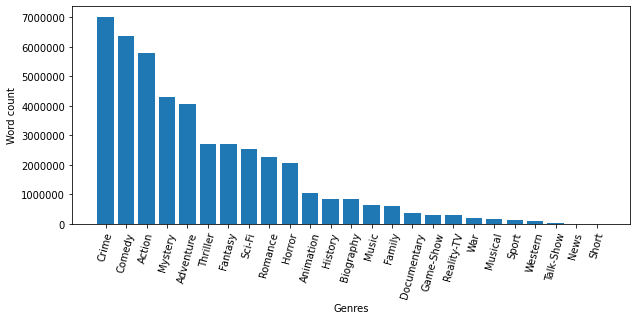

In [ ]:
_sorted_genres = []
_sorted_counts = []
for genre, count in sorted_genre_word_count:
  if genre != "Drama":
    _sorted_genres.append(genre)
    _sorted_counts.append(count)
plt.figure(figsize=(10,4))
plt.bar(_sorted_genres, _sorted_counts)
plt.xticks(rotation=75)
plt.yscale('linear')
plt.tick_params(axis="x", which="major", labelsize=10)
plt.ticklabel_format(axis="y", style="plain")
plt.xlabel("Genres")
plt.ylabel("Word count")
plt.show()

A distribuição depende da escolha inicial aleatória de amostra. Contudo, em termos gerais, o gênero de Drama costuma ficar em primeiro lugar em quantidade de palavras, com mais que o dobro do que o segundo lugar, Crime. Assim, é de nosso interesse **remover Drama do dataset**.

Palavras mais comuns (e suas ocorrências):

In [ ]:
sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:10]

[('e', 986332),
 ('que', 976122),
 ('nao', 782413),
 ('o', 755032),
 ('de', 602782),
 ('a', 585834),
 ('est', 558042),
 ('voc', 543950),
 ('eu', 425710),
 ('com', 392120)]

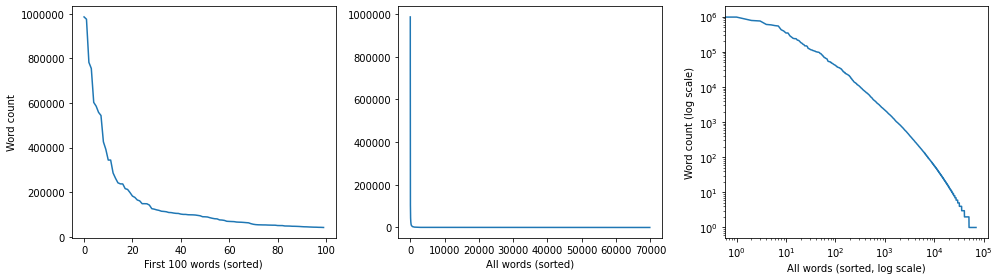

In [ ]:
word_count_values = sorted(word_count.values(), reverse=True)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
ax1.plot(range(100), word_count_values[:100])
ax1.ticklabel_format(axis="y", style="plain")
ax1.set_ylabel("Word count")
ax1.set_xlabel("First 100 words (sorted)")
ax2.plot(range(len(word_count_values)), word_count_values)
ax2.ticklabel_format(axis="y", style="plain")
ax2.set_xlabel("All words (sorted)")

ax3.plot(range(len(word_count_values)), word_count_values)
ax3.ticklabel_format(axis="y", style="plain")
ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_ylabel("Word count (log scale)")
ax3.set_xlabel("All words (sorted, log scale)")

fig.tight_layout()

Similarmente com os gêneros, temos algumas palavras que absolutamente dominam o dataset. Isso, contudo, é previsto em parte pela [Lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law). Assim, podemos eliminar as palavras mais comuns, que provavelmente estão presentes em todos os filmes, e as mais incomuns, que estão presentes em somente um filme.

### Tratamento (B)

Vamos abaixo fazer as modificações, então: remoção de Drama, das 100 (valor arbitrário) palavras mais comuns, e de palavras com apenas 1 ocorrência. O processo será similar à criação de conjuntos no início desse bloco, porém agora com aplicação de regras.

In [25]:
# Create list of 100 most common words from corpus
most_common_words = [w for (w,_) in sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:100]]
most_common_words[:10]

['e', 'que', 'nao', 'o', 'de', 'a', 'est', 'voc', 'eu', 'com']

In [26]:
# Create list of all words with only 1 occurence
least_common_words = [w for (w,_) in [k for k in sorted(word_count.items(), key=lambda x: x[1]) if k[1] <= 1]]
least_common_words[:10]

['concur',
 'supon',
 'wel',
 'surpefici',
 'sabemquetemexat',
 'saliniz',
 'esquadraoflash',
 'weduwmak',
 'toux',
 'fgd']

In [27]:
print(f"Found {len(least_common_words)} words with only 1 occurence")

Found 19562 words with only 1 occurence


In [28]:
# Cria acesso O(1) à inclusão de palavras na blacklist
blacklist_dict = {}
for word in most_common_words:
  blacklist_dict[word] = True
for word in least_common_words:
  blacklist_dict[word] = True

In [29]:
# Reinicia os conjuntos
all_genres_set = set()
all_words_set = set()

# Novamente, para cada par gêneros/palavras
for genres, words in genre_word_pairs:
  for genre in genres:
    if genre != "Drama":
      all_genres_set.add(genre)
  # Adiciona todas as palavras ao conjunto
  for word in words:
    if word not in blacklist_dict:
      all_words_set.add(word)

all_genres_count = len(all_genres_set)
all_words_count = len(all_words_set)

In [30]:
print(f"Found {all_genres_count} distinct genres and {all_words_count} distinct words\n")
print("Genres:", all_genres_set)

Found 25 distinct genres and 49849 distinct words

Genres: {'Biography', 'History', 'Animation', 'News', 'Comedy', 'Romance', 'Sci-Fi', 'Western', 'Game-Show', 'Short', 'Mystery', 'Adventure', 'War', 'Talk-Show', 'Crime', 'Musical', 'Sport', 'Reality-TV', 'Horror', 'Fantasy', 'Action', 'Documentary', 'Thriller', 'Family', 'Music'}


## Vetorização

Criação dos vetores para serem usados pelo Fuzzy kNN:

- `X` é uma matriz onde cada linha representa um filme, e cada coluna representa uma palavra. Os valores são as frequências relativas de cada palavra naquele filme, como porcentagem onde $X_{ij} \in [0, 100]$.
- `y` é um vetor de gêneros de filme. Cada linha representa o mesmo filme da linha correspondente em `X`, e cada coluna é a porcentagem de inclusão em um gênero específico, na ordem da lista completa de gêneros de filmes. Assim, $y_{mn} \in [0, 100]$.

In [31]:
all_genres_list = list(all_genres_set)
all_words_list = list(all_words_set)

# Cria um acesso O(1) para o índice de todas as palavras
word_indexes = {}
for i in range(all_words_count):
  word = all_words_list[i]
  word_indexes[word] = i

In [32]:
# Vetor "X" contendo listas de frequências de cada palavra
X = []
# Vetor "y" contendo os gêneros 
y = []

# Para cada par da lista de filmes
for genres, words in genre_word_pairs:
  # Cria lista de 0's que terão a frequência de cada palavra
  word_frequencies = np.zeros(all_words_count)
  # Para cada palavra do filme
  for word in words:
    # Se não encontrou a palavra na lista geral, pula
    if word not in word_indexes:
      continue
    # Caso contrário, pega o índice da palavra na lista
    word_index = word_indexes[word]
    word_frequencies[word_index] += 1
  # Frequências de cada palavra em porcentagem, [0, 100]
  word_frequencies = 100 * word_frequencies / sum(word_frequencies)
  # Adiciona ao vetor X as frequências das palavras
  X.append(word_frequencies)
  ######
  # Cria lista de 0's que terão a frequência de cada gênero
  genre_frequencies = np.zeros(all_genres_count)
  # Para cada gênero do filme
  for genre in genres:
    # Se não encontrou o gênero na lista geral, pula
    if genre not in all_genres_set:
      continue
    # Caso contrário, pega o índice do gênero na lista, adiciona porcentagem na frequência
    genre_index = all_genres_list.index(genre)
    genre_frequencies[genre_index] = 100 / len(genres) # Pseudo-problema se sair pelo continue acima mas e daí
  # Adiciona ao vetor y as frequências dos gêneros
  y.append(genre_frequencies)

In [33]:
# Remove vetores que só possuem 0's
# (por algum motivo podem exitir)
remove_indexes = []
for i in range(len(X)):
  if np.count_nonzero(X[i]) <= 0:
    remove_indexes.append(i)
X = np.delete(X, remove_indexes, axis=0)
y = np.delete(y, remove_indexes, axis=0)

In [34]:
print(f"Line count of X should be equal to that of y: {len(X)} == {len(y)}")

Line count of X should be equal to that of y: 6867 == 6867


Divide dataset em 80% para "treino", 20% para "testes"

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(f"Train size: {len(X_train)}; Test size: {len(X_test)}")

Train size: 6180; Test size: 687


# Testes

Entrando aqui, devemos já ter `X_train`, `X_test`, `y_train` e `y_test` definidos.

In [36]:
# Distância n-dimensional
def distance(a, b):
  return math.sqrt(np.sum(np.square(np.subtract(a, b))))

# Como a operação de distância é realizada muitas
# milhares de vezes, precisamos otimizá-la de alguma
# forma. Por exemplo, a raiz quadrada só é necessária
# para calcular o erro; para o resto, a "meia"
# distância já é suficiente
def half_distance(a, b):
  return np.sum(np.square(np.subtract(a, b)))

## FkNN

Implementação do Fuzzy-kNN como descrita por Keller et al. (1985):

In [37]:
# Implementação básica do Fuzzy-KNN
# Baseada em Keller et al., 1985
#   K : Número de vizinhos mais próximos
#   x : "Ponto" sendo classificado
#   X : Conjunto de pontos de treino
#   y : Classificação dos pontos de treino
#   m : "How heavily the distance is weighted"; default m = 2
def FKNN(K, x, X, y, m=2):
  # Computa os 'K' vizinhos mais próximos
  KNN = []
  best_dist = float("inf")# = ∞
  for i in range(len(X)):
    #dist = distance(x, X[i])
    dist = half_distance(x, X[i]) # Cálculo mais otimizado de distância
    if i < K:
      KNN.append([ X[i], y[i], dist ])
      KNN.sort(key=lambda a: a[2])
    elif dist < best_dist:
      KNN.pop()
      KNN.append([ X[i], y[i], dist ])
      KNN.sort(key=lambda a: a[2])
  # Agora temos os K-nearest neighbors no array 'KNN', falta calcular o fuzzy

  # u[i](x) = assigned membership of the vector x (to be computed)
  # u[ij] = membership in the i'th class of the j'th vector of the labeled sample set

  classification = np.zeros(all_genres_count)
  exponent = 2 / (m - 1)
  # Para cada classe possível
  for i in range(all_genres_count):
    top_sum = 0
    bottom_sum = 0
    for j in range(K):
      # Calcula a parte de baixo, que independe de outros vetores
      xj = KNN[j][0]
      # 1 / (|| x − xⱼ || ^ (2/(m-1)))
      sub = np.subtract(x, xj)
      # Confere se o vetor só possui 0s para evitar divisão por zero
      if not np.count_nonzero(sub):
        #print(f"!!! Division by 0 on i='{i}', j='{j}' !!!")
        continue
      addend = 1 / (np.linalg.norm(sub) ** exponent)
      bottom_sum += addend
      # Calcula a parte de cima, pegando cada classe individualmente do vizinho
      uij = KNN[j][1][i]
      top_sum += uij * addend
    if bottom_sum == 0:
      print(f"!!! Division by 0 on i='{i}' !!!")
      continue
    # Adiciona a divisão de cima por baixo ao vetor de classificações
    classification[i] = top_sum / bottom_sum
  return classification

In [40]:
def printGenres(array):
  indexes = reversed(np.argsort(array))
  for i, guess in zip(indexes, reversed(sorted(array))):
    if guess <= 0: break
    print(f"\t{all_genres_list[i]}: {guess:.2f}")

### Detecção de melhor K

(pode ser pulado)

Teste com valores diferentes para K:

In [106]:
def findBestK(test_count, rng, X_test, y_test, X_train, y_train, silent=False):
  test_indexes = np.random.choice(len(X_test), test_count, replace=False)
  print(f"Picked {test_count} random indexes to check")
  ks = []
  ws = []
  i = 0
  for index in test_indexes:
    if i % 20 == 0: print(f"{i}/{test_count}")
    best_k = None
    best_guess = None
    best_error = float("inf")
    errors = []
    for k in rng:
      guess = FKNN(k, X_test[index], X_train, y_train)
      error = distance(guess, y_test[index])
      errors.append(error)
      if error < best_error:
        best_k = k
        best_guess = guess
        best_error = error
    ks.append(best_k)
    ws.append(best_error)
    if not silent:
      print(f"Best error had K={best_k} (at index {index})")
      print(f"Error: {best_error:.2f}")
      print("Guess:")
      printGenres(best_guess)
      print("Truth:")
      printGenres(y_test[index])
      plt.scatter(list(rng), errors, c="r")
      plt.ylabel("Error")
      plt.ylim([0, 100])
      plt.xlabel("K")
      plt.show()
    i += 1
  return ks, ws

Demonstração do que a função faz com 3 exemplos:

Picked 3 random indexes to check
0/3
Best error had K=3 (at index 382)
Error: 0.49
Guess:
	Comedy: 99.55
	Crime: 0.15
	Thriller: 0.08
	Mystery: 0.07
Truth:
	Comedy: 100.00


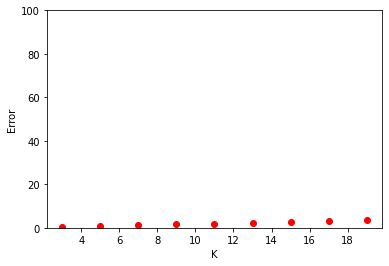

Best error had K=3 (at index 505)
Error: 41.29
Guess:
	Horror: 36.31
	Comedy: 18.23
	Thriller: 18.09
	Mystery: 9.12
	Crime: 9.12
Truth:
	Thriller: 50.00
	Horror: 50.00


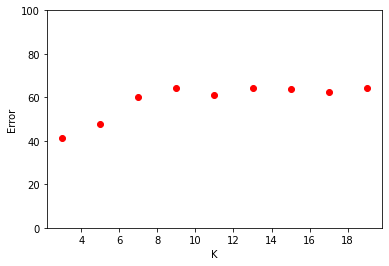

Best error had K=17 (at index 402)
Error: 47.64
Guess:
	Comedy: 14.30
	Action: 9.85
	Sci-Fi: 9.85
	Adventure: 9.85
	Romance: 8.79
	Biography: 5.75
	Thriller: 5.75
	Family: 1.98
	Crime: 1.67
	Mystery: 1.67
Truth:
	Romance: 50.00


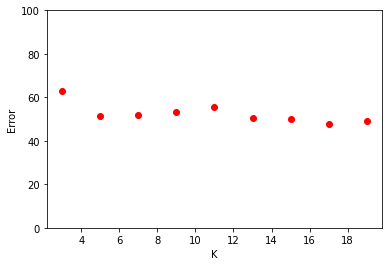

([3, 3, 17], [0.4884211127613351, 41.28555710629274, 47.64077658341075])

In [107]:
findBestK(3, range(3, 20, 2), X_test, y_test, X_train, y_train)

Agora, para valer, procurando o melhor K médio para todos os pontos de teste:

In [ ]:
ks, ws = findBestK(len(X_test), range(3, 20, 2), X_test, y_test, X_train, y_train, silent=True)

Picked 690 random indexes to check
0/690
20/690
40/690
60/690
80/690
100/690
120/690
140/690
160/690
180/690
200/690
220/690
240/690
260/690
280/690
300/690
320/690
340/690
360/690
380/690
400/690
420/690
440/690
460/690
480/690
500/690
520/690
540/690
560/690
580/690
600/690
620/690
640/690
660/690
680/690


In [ ]:
summed_error = {}
for i in range(len(ks)):
  k = ks[i]
  if k not in summed_error:
    summed_error[k] = 0
  summed_error[k] += ws[i]
summed_error

{3: 4915.670888189216,
 5: 2400.431481008534,
 7: 1459.968434502335,
 9: 1000.5114332525106,
 11: 611.0424153305574,
 13: 1069.314267177412,
 15: 919.7902493414515,
 17: 1497.815658725509,
 19: 4108.050132937079}

In [ ]:
best_k = 0
smallest_error = float("inf")
for k, v in summed_error.items():
  if v < smallest_error:
    smallest_error = v
    best_k = k
best_k

11

### Cálculo do erro

In [108]:
best_k = 11

#### Função de erro

In [187]:
# Calcula erro entre duas classificações
# Retorna um valor entre 0 e 1
# 0 - Iguais nos 
def error(a, b, tolerance=5):
  size = its = min(len(a), len(b), tolerance)
  acc = 0
  for i in reversed(np.argsort(a)):
    if its <= 0: break
    acc += abs(a[i] - b[i])/100
    its -= 1
  return acc/2

In [188]:
error(
[33.33, 33.33, 33.33,  0.00, 0.00],
[ 0.00, 28.34, 28.34, 28.34, 7.49]
)# ?

0.39569999999999994

In [191]:
error(
[100.0, 0.00, 0.00, 0.00],
[99.55, 0.15, 0.08, 0.07]
)# erro muito baixo

0.0037500000000000146

In [192]:
error(
[50.00,  0.00,  0.00],
[49.62,  5.35,  4.91]
)# erro baixo

0.05320000000000001

In [193]:
error(
[50.0, 50.0,   0.0],
[ 0.0,  0.0, 100.0]
)# erro deveria ser 1

1.0

#### Cálculo do erro para pontos

In [194]:
def getError(K, X_test, y_test, X_train, y_train):
  distances = []
  errors = []
  total_entries = len(X_test)
  for i in range(total_entries):
    if i % 20 == 0:
      print(f"Calculating error for K={K}, N={total_entries}, index {i}")
    guess = FKNN(K, X_test[i], X_train, y_train)
    distances.append(distance(guess, y_test[i]))
    errors.append(error(guess, y_test[i]))
  return distances, errors

In [195]:
dists, errs = getError(best_k, X_test, y_test, X_train, y_train)

Calculating error for K=11, N=687, index 0
Calculating error for K=11, N=687, index 20
Calculating error for K=11, N=687, index 40
Calculating error for K=11, N=687, index 60
Calculating error for K=11, N=687, index 80
Calculating error for K=11, N=687, index 100
Calculating error for K=11, N=687, index 120
Calculating error for K=11, N=687, index 140
Calculating error for K=11, N=687, index 160
Calculating error for K=11, N=687, index 180
Calculating error for K=11, N=687, index 200
Calculating error for K=11, N=687, index 220
Calculating error for K=11, N=687, index 240
Calculating error for K=11, N=687, index 260
Calculating error for K=11, N=687, index 280
Calculating error for K=11, N=687, index 300
Calculating error for K=11, N=687, index 320
Calculating error for K=11, N=687, index 340
Calculating error for K=11, N=687, index 360
Calculating error for K=11, N=687, index 380
Calculating error for K=11, N=687, index 400
Calculating error for K=11, N=687, index 420
Calculating erro

In [246]:
def plotError(arr, yrange=None):
  avg = np.average(arr)
  stddev = np.std(arr)
  print(f"Average error: {avg:.2f}")
  print(f"Median error: {np.median(arr):.2f}")
  print(f"Std. Dev.: {stddev:.2f}")
  print(f"Min. error: {np.amin(arr):.20f}")
  print(f"Max. error: {np.amax(arr):.20f}")

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 4), gridspec_kw={"width_ratios": [1, 5]})

  ax1.scatter([1]*len(arr), arr, color=[1,0,0,0.025])
  ax1.set_ylabel("Error")
  ax1.set_xlabel("Films")
  ax1.set_xticks([])
  ax1.axhline(y=avg, color="b", linestyle="-")
  ax1.axhline(y=avg+stddev, color="c", linestyle="-")
  ax1.axhline(y=avg-stddev, color="c", linestyle="-")
  if yrange: ax1.set_ylim(yrange)

  ax2.scatter(list(range(len(arr))), arr, color=[1,0,0,0.25])
  ax2.set_xlabel("Films (\"side\" view)")
  ax2.set_xticks([])
  ax2.axhline(y=avg, color="b", linestyle="-")
  ax2.axhline(y=avg+stddev, color="c", linestyle="-")
  ax2.axhline(y=avg-stddev, color="c", linestyle="-")
  if yrange: ax2.set_ylim(yrange)

  fig.tight_layout()

Average error: 31.74
Median error: 30.53
Std. Dev.: 26.25
Min. error: 0.00000000000001004859
Max. error: 108.14656139180281968493


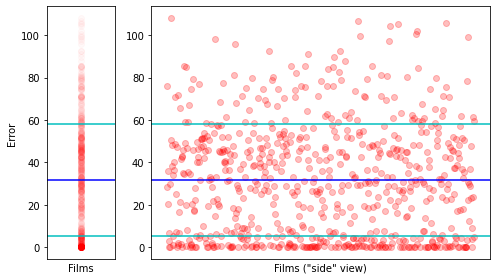

In [247]:
plotError(dists)

Average error: 0.24
Median error: 0.27
Std. Dev.: 0.19
Min. error: 0.00000000000000007105
Max. error: 0.84127586190238534680


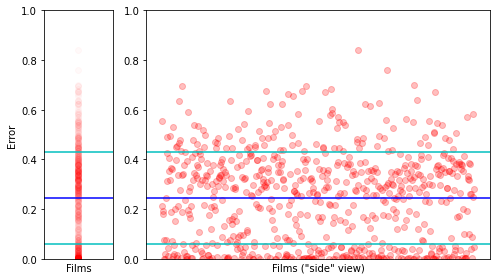

In [248]:
plotError(errs, yrange=[0,1])

In [249]:
len([x for x in errs if x < 0.05])/len(errs)

0.2590975254730713